In [14]:
# from mpi4py import MPI
# import gmsh

# # Initialize gmsh
# gmsh.initialize()
# gmsh.model.add("rect_with_partial_interface")

# if MPI.COMM_WORLD.rank == 0:
#     # --------------------------
#     # Parameters
#     # --------------------------
#     Lx, Ly = 1.0, 1.0
#     y_interface = 0.5
#     x_start, x_end = 0.1, 0.8
#     lc = 0.01          # mesh size
#     order = 2          # element order

#     # --------------------------
#     # 1. Define rectangular domain Ω
#     # --------------------------
#     p1 = gmsh.model.occ.addPoint(0, 0, 0, lc)
#     p2 = gmsh.model.occ.addPoint(Lx, 0, 0, lc)
#     p3 = gmsh.model.occ.addPoint(Lx, Ly, 0, lc)
#     p4 = gmsh.model.occ.addPoint(0, Ly, 0, lc)
#     l1 = gmsh.model.occ.addLine(p1, p2)
#     l2 = gmsh.model.occ.addLine(p2, p3)
#     l3 = gmsh.model.occ.addLine(p3, p4)
#     l4 = gmsh.model.occ.addLine(p4, p1)
#     loop = gmsh.model.occ.addCurveLoop([l1, l2, l3, l4])
#     surf = gmsh.model.occ.addPlaneSurface([loop])

#     # --------------------------
#     # 2. Add an internal partial horizontal line Γ
#     # --------------------------
#     p5 = gmsh.model.occ.addPoint(x_start, y_interface, 0, lc)
#     p6 = gmsh.model.occ.addPoint(x_end, y_interface, 0, lc)
#     l5 = gmsh.model.occ.addLine(p5, p6)

#     # --------------------------
#     # 3. Fragment the surface with the internal line (split mesh)
#     # --------------------------
#     gmsh.model.occ.fragment([(2, surf)], [(1, l5)])
#     gmsh.model.occ.synchronize()

#     # --------------------------
#     # 4. Define physical groups
#     # --------------------------
#     # Surface (bulk Ω)
#     gmsh.model.addPhysicalGroup(2, [surf], 1)
#     gmsh.model.setPhysicalName(2, 1, "Omega")

#     # Identify the internal line (Γ)
#     all_lines = gmsh.model.getEntities(dim=1)
#     # print(all_lines)
#     gamma_tag = all_lines[0][1]  # the last 1D entity created
#     gmsh.model.addPhysicalGroup(1, [gamma_tag], 2)
#     gmsh.model.setPhysicalName(1, 2, "Gamma")

#     # Optionally, tag boundary (outer edges)
#     outer_edges = [l1, l2, l3, l4]
#     gmsh.model.addPhysicalGroup(1, outer_edges, 3)
#     gmsh.model.setPhysicalName(1, 3, "Boundary")

#     # --------------------------
#     # 5. Generate and save mesh
#     # --------------------------
#     gmsh.model.mesh.generate(2)
#     gmsh.model.mesh.setOrder(order)
#     gmsh.write("horizontal.msh")

# gmsh.finalize()


In [15]:
from mpi4py import MPI
from dolfinx import mesh, fem
import ufl
import numpy as np

# ---------------------------------------------------------------------
# 1. Mesh and interface tags (similar to Γ tagging in the workshop)
# ---------------------------------------------------------------------
# Load Gmsh mesh (2D bulk Ω + 1D interface Γ)
from dolfinx.io import gmsh as gmshio
# Read the same .msh
msh, cell_markers, facet_markers = gmshio.read_from_msh("horizontal.msh", MPI.COMM_WORLD, 0, gdim=2)[0:3]


# Extract the 1D interface mesh from the 2D mesh (like igridView)
# interface = mesh.create_submesh(domain, domain.topology.dim - 1, np.arange(domain.topology.index_map(domain.topology.dim - 1).size_local, dtype=np.int32))[0]


Info    : Reading 'horizontal.msh'...
Info    : 12 entities
Info    : 46965 nodes
Info    : 23352 elements
Info    : Done reading 'horizontal.msh'


In [16]:
tdim = msh.topology.dim  # 2
fdim = tdim - 1             # 1

# Find all facets tagged as Gamma (tag=2)
omega = msh
gamma_entities = facet_markers.find(2)

# Create a submesh for Γ (same as gamma in the JSDokken example)
gamma, gamma_to_omega = mesh.create_submesh(omega, fdim, gamma_entities)[0:2]

In [17]:
print(gamma.geometry.x[:])

[[0.1   0.5   0.   ]
 [0.11  0.5   0.   ]
 [0.105 0.5   0.   ]
 [0.12  0.5   0.   ]
 [0.115 0.5   0.   ]
 [0.13  0.5   0.   ]
 [0.125 0.5   0.   ]
 [0.14  0.5   0.   ]
 [0.135 0.5   0.   ]
 [0.15  0.5   0.   ]
 [0.145 0.5   0.   ]
 [0.16  0.5   0.   ]
 [0.155 0.5   0.   ]
 [0.17  0.5   0.   ]
 [0.165 0.5   0.   ]
 [0.18  0.5   0.   ]
 [0.175 0.5   0.   ]
 [0.19  0.5   0.   ]
 [0.185 0.5   0.   ]
 [0.2   0.5   0.   ]
 [0.195 0.5   0.   ]
 [0.21  0.5   0.   ]
 [0.205 0.5   0.   ]
 [0.22  0.5   0.   ]
 [0.215 0.5   0.   ]
 [0.23  0.5   0.   ]
 [0.225 0.5   0.   ]
 [0.24  0.5   0.   ]
 [0.235 0.5   0.   ]
 [0.25  0.5   0.   ]
 [0.245 0.5   0.   ]
 [0.26  0.5   0.   ]
 [0.255 0.5   0.   ]
 [0.27  0.5   0.   ]
 [0.265 0.5   0.   ]
 [0.28  0.5   0.   ]
 [0.275 0.5   0.   ]
 [0.29  0.5   0.   ]
 [0.285 0.5   0.   ]
 [0.3   0.5   0.   ]
 [0.295 0.5   0.   ]
 [0.31  0.5   0.   ]
 [0.305 0.5   0.   ]
 [0.32  0.5   0.   ]
 [0.315 0.5   0.   ]
 [0.33  0.5   0.   ]
 [0.325 0.5   0.   ]
 [0.34  0.5  

In [18]:
# Define interface tag ID (as defined in Gmsh)
Gamma_tag = 2  # <-- replace with your actual tag ID for the interface Γ

# ---------------------------------------------------------------------
# 2. Function spaces
# ---------------------------------------------------------------------
order = 2
V_m = fem.functionspace(omega, ("Lagrange", order))  # bulk Ω
V_f = fem.functionspace(gamma, ("Lagrange", order))   # interface Γ
V_l = fem.functionspace(gamma, ("Lagrange", order))   # multiplier space on Γ
W = ufl.MixedFunctionSpace(V_m, V_f, V_l)

# ---------------------------------------------------------------------
# 3. Trial and Test functions
# ---------------------------------------------------------------------
phi, psi, mu = ufl.TestFunctions(W)
dp_m, dp_f, dl = ufl.TrialFunctions(W)
p_m = fem.Function(V_m, name="p_m")
p_f = fem.Function(V_f, name="p_f")
lmbd = fem.Function(V_f, name="lmbd")

# ---------------------------------------------------------------------
# 4. Spatial coordinates and given data
# ---------------------------------------------------------------------
x = ufl.SpatialCoordinate(msh)
f_m = fem.Constant(msh, 0.0)
f_f = fem.Constant(msh, 0.0)

k_m = fem.Constant(omega, 1.0)
k_f = fem.Constant(gamma, 100.0)


In [19]:
dx = ufl.Measure("dx", domain=omega)
ds = ufl.Measure("ds", domain=omega, subdomain_data=facet_markers, subdomain_id=Gamma_tag)
dx_f = ufl.Measure("dx", domain=gamma)

In [20]:
# ---------------------------------------------------------------------
# 5. Weak formulations
# ---------------------------------------------------------------------

# --- Bulk domain Ω ---------------------------------------------------
a_m0 = ufl.inner(k_m * ufl.grad(p_m), ufl.grad(phi)) * dx
# Coupling term with interface (approximate; corresponds to avg/trace in DUNE)
# In the Dokken example, coupling to Γ is done via ds(Gamma_tag)
# Here we use the interface integral directly on ds(Gamma_tag)
# (You can later replace lmbd with an actual trace variable or interface function)
a_m1 = -lmbd * phi * ds
a_m = a_m0 + a_m1
L_m = f_m * phi * dx

# --- Interface Γ -----------------------------------------------------
a_f0 = ufl.inner(k_f * ufl.grad(p_f), ufl.grad(psi)) * ds
a_f1 = lmbd * psi * ds
a_f = a_f0 + a_f1
L_f = f_f * psi * ds
# a_f0 = ufl.inner(ufl.grad(p_f), ufl.grad(psi)) * dx_f
# a_f1 = lmbd * psi * dx_f
# a_f = a_f0 + a_f1
# L_f = f_f * psi * dx_f

# --- Lagrange multiplier (constraint tr(p_m) = p_f) ------------------
# Dokken’s example handles this through interface coupling on ds(Gamma_tag)
a_l0 = p_m * mu * ds
a_l1 = -p_f * mu * ds
a_l = a_l0 + a_l1
L_l = fem.Constant(msh, 0.0) * mu * ds

# a_l0 = p_m * mu * ds
# a_l1 = -p_f * mu * dx_f
# a_l = a_l0 + a_l1
# L_l = fem.Constant(msh, 0.0) * mu * dx_f

# ---------------------------------------------------------------------
# 6. Combine interface weak form
# ---------------------------------------------------------------------
a_gamma = a_f + a_l
L_gamma = L_f + L_l

# ---------------------------------------------------------------------
# Print symbolic forms (optional sanity check)
# ---------------------------------------------------------------------
print("a_m =", a_m)
print("a_gamma =", a_gamma)

a_m = { ({ A | A_{i_{35}} = c_7 * (grad(p_m))[i_{35}] }) : (grad(v_0^0)) } * dx(<Mesh #2>[everywhere], {})
  +  { v_0^0 * -1 * lmbd } * ds(<Mesh #2>[2], {})
a_gamma = { ({ A | A_{i_{36}} = c_8 * (grad(p_f))[i_{36}] }) : (grad(v_0^1)) } * ds(<Mesh #2>[2], {})
  +  { v_0^1 * lmbd } * ds(<Mesh #2>[2], {})
  +  { v_0^2 * p_m } * ds(<Mesh #2>[2], {})
  +  { v_0^2 * -1 * p_f } * ds(<Mesh #2>[2], {})


In [21]:
F = a_m - L_m + a_gamma - L_gamma
residual = ufl.extract_blocks(F)

In [22]:
jac = ufl.derivative(F, p_m, dp_m) + ufl.derivative(F, p_f, dp_f) + ufl.derivative(F, lmbd, dl)
J = ufl.extract_blocks(jac)

In [23]:
# Compute bounding box to locate sides
coords = omega.geometry.x
x = coords[:, 0]
y = coords[:, 1]

xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()

# Tolerance for side detection
tol = 1e-10 * max(xmax - xmin, ymax - ymin)

# Locate dofs on each side
left_dofs   = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[0], xmin, atol=tol))
right_dofs  = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[0], xmax, atol=tol))
bottom_dofs = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[1], ymin, atol=tol))
top_dofs    = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[1], ymax, atol=tol))

# Union of all boundary dofs for which we enforce a value
all_dofs = np.unique(np.concatenate([left_dofs, right_dofs, bottom_dofs, top_dofs]))

# Build a Function-valued BC so we can assign side-dependent values
p_m_bc = fem.Function(V_m)
p_m_bc.x.array[:] = 0.0  # default 0 (bottom + right)
p_m_bc.x.array[left_dofs] = 1.0
p_m_bc.x.array[top_dofs]  = 1.0

# One BC object over the union of dofs with piecewise values
bc_pm = fem.dirichletbc(p_m_bc, all_dofs)

bcs = [bc_pm]

In [24]:
print("DOFs in p_m:", p_m.function_space.dofmap.index_map.size_global)
print("DOFs in p_f:", p_f.function_space.dofmap.index_map.size_global)
print("DOFs in λ:", lmbd.function_space.dofmap.index_map.size_global)
total_dofs = (
    p_m.function_space.dofmap.index_map.size_global
    + p_f.function_space.dofmap.index_map.size_global
    + lmbd.function_space.dofmap.index_map.size_global
)
print("Total DOFs:", total_dofs)


DOFs in p_m: 46965
DOFs in p_f: 141
DOFs in λ: 141
Total DOFs: 47247


In [25]:
from dolfinx.fem import petsc
entity_maps = [gamma_to_omega]
# --- Assemble J once (with entity_maps) ---
A = petsc.assemble_matrix(
    fem.form(J, entity_maps=entity_maps),  # <-- pass it here
    bcs=bcs,
)
A.assemble()

In [26]:


# entity_maps = [gamma_to_omega]

nlp = petsc.NonlinearProblem(
    residual,
    u=[p_m, p_f, lmbd],
    J=J,
    bcs=bcs,
    entity_maps=entity_maps,
    petsc_options={
        "snes_monitor": None,
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
        "mat_mumps_icntl_14": 120,
        "ksp_error_if_not_converged": True,
        "snes_error_if_not_converged": True,
    },
    petsc_options_prefix="pmix_",
)
max_iterations = 25
normed_diff = 0
tol = 1e-5

nlp.solve()
iterations = nlp.solver.getIterationNumber()
print(f"Converged in {iterations} Newton iterations")



# entity_maps = [gamma_to_omega]
# a = a_m + a_gamma
# L = L_m + L_gamma
# problem = petsc.LinearProblem(
#     a, L,
#     bcs=bcs,
#     entity_maps=entity_maps,
#     u=[p_m, p_f, lmbd],
#     petsc_options={
#         "ksp_type": "preonly",
#         "pc_type": "lu",
#         "pc_factor_mat_solver_type": "mumps",        # or "superlu_dist"
#         "ksp_error_if_not_converged": True,
#     },
#     petsc_options_prefix="pmix_"
# )

# U = problem.solve()          # U is a Function in W
# max_iterations = 25
# normed_diff = 0
# tol = 1e-5

# nlp.solve()
# iterations = nlp.solver.getIterationNumber()
# print(f"Converged in {iterations} Newton iterations")

  0 SNES Function norm 3.933626025346e+01
  1 SNES Function norm 1.108002622502e+00
  2 SNES Function norm 6.700570281628e-01
  3 SNES Function norm 4.479881935852e-01
  4 SNES Function norm 2.920781315299e-01
  5 SNES Function norm 1.912155964853e-01
  6 SNES Function norm 1.250357331036e-01
  7 SNES Function norm 8.159471943221e-02
  8 SNES Function norm 5.313755651097e-02
  9 SNES Function norm 3.453800802931e-02
 10 SNES Function norm 2.241410549299e-02
 11 SNES Function norm 1.452825156083e-02
 12 SNES Function norm 9.408172344412e-03
 13 SNES Function norm 6.088338530490e-03
 14 SNES Function norm 3.937984634553e-03
 15 SNES Function norm 2.546188533558e-03
 16 SNES Function norm 1.645859433553e-03
 17 SNES Function norm 1.063684609006e-03
 18 SNES Function norm 6.873444074368e-04
 19 SNES Function norm 4.441137185612e-04
 20 SNES Function norm 2.869355226328e-04
 21 SNES Function norm 1.853759612610e-04
 22 SNES Function norm 1.197588512843e-04
 23 SNES Function norm 7.736620606

/home/muchamad/PhD/fenicsx/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


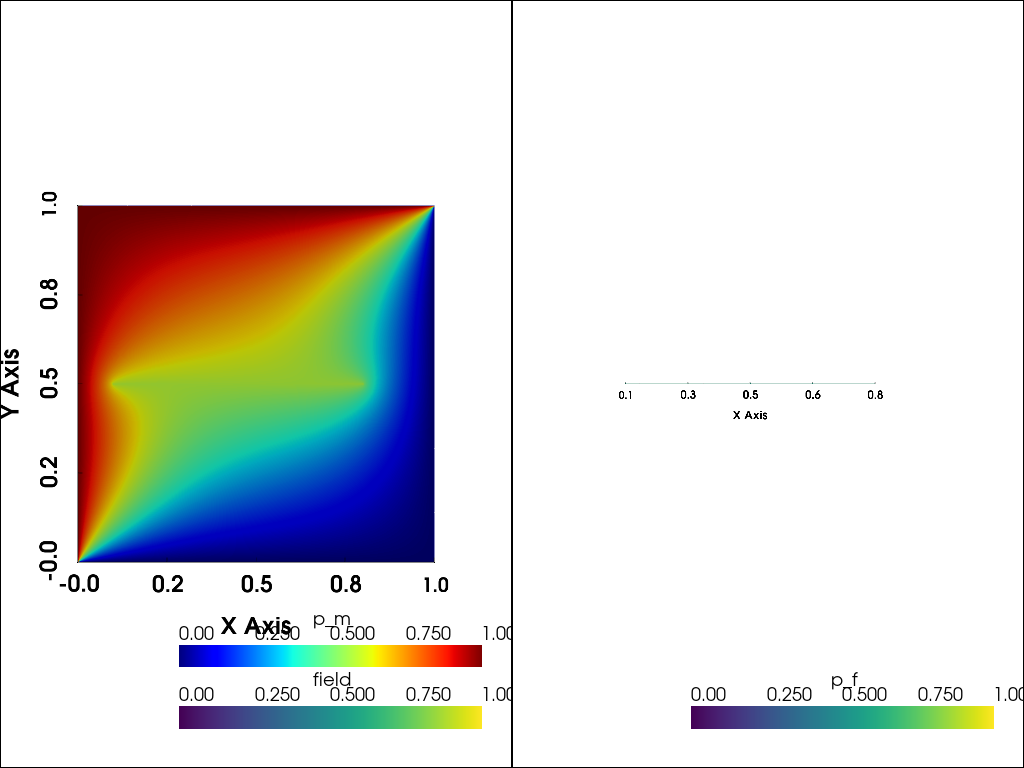

In [64]:
import numpy as np
import pyvista as pv
import dolfinx
from dolfinx import plot

# --- helper: build a PyVista grid from a scalar Function (CG or DG) ---
def function_to_pyvista_grid(u):
    # Newer dolfinx uses create_vtk_mesh; fall back to vtk_mesh if needed
    try:
        topology, cell_types, geometry = plot.create_vtk_mesh(u.function_space)
    except AttributeError:
        topology, cell_types, geometry = plot.vtk_mesh(u.function_space)

    grid = pv.UnstructuredGrid(topology, cell_types, geometry)

    # Attach scalar values on points
    # For scalar fields, u.x.array is 1D of length n_dofs
    values = u.x.array
    # If the FE space is vector-valued, drop to first component (not expected here)
    if values.ndim > 1:
        values = values.reshape(-1)
    grid.point_data["field"] = values.real  # use .real in case of complex
    return grid

# --- Build PyVista grids for p_m and p_f ---
grid_pm = function_to_pyvista_grid(p_m)
grid_pf = function_to_pyvista_grid(p_f)

# Optional: consistent ranges so the color scales match (remove if you prefer autoscale)
vmin = min(grid_pm.point_data["field"].min(), grid_pf.point_data["field"].min())
vmax = max(grid_pm.point_data["field"].max(), grid_pf.point_data["field"].max())

# --- Plot side-by-side, inspired by your style (wireframe + shaded) ---
plotter = pv.Plotter(shape=(1, 2), border=True)

# Left: p_m
plotter.subplot(0, 0)
plotter.add_mesh(grid_pm.copy(deep=True), style="wireframe", color="b")
plotter.add_mesh(
    grid_pm, scalars="field", show_edges=False, lighting=True, clim=[vmin, vmax],cmap='jet'
)
plotter.add_scalar_bar(title="p_m")
plotter.show_bounds()
plotter.view_xy()

# Right: p_f
plotter.subplot(0, 1)
plotter.add_mesh(grid_pf.copy(deep=True), style="wireframe", color="b")
plotter.add_mesh(
    grid_pf, scalars="field", show_edges=True, lighting=True, clim=[vmin, vmax]
)
plotter.add_scalar_bar(title="p_f")
plotter.show_bounds()
plotter.view_xy()

# Link cameras so rotations/zooms match
plotter.link_views()
plotter.show()


In [65]:
grid_pf

UnstructuredGrid (0x786908160340)
  N Cells:    70
  N Points:   141
  X Bounds:   1.000e-01, 8.000e-01
  Y Bounds:   5.000e-01, 5.000e-01
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   1

/home/muchamad/PhD/fenicsx/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


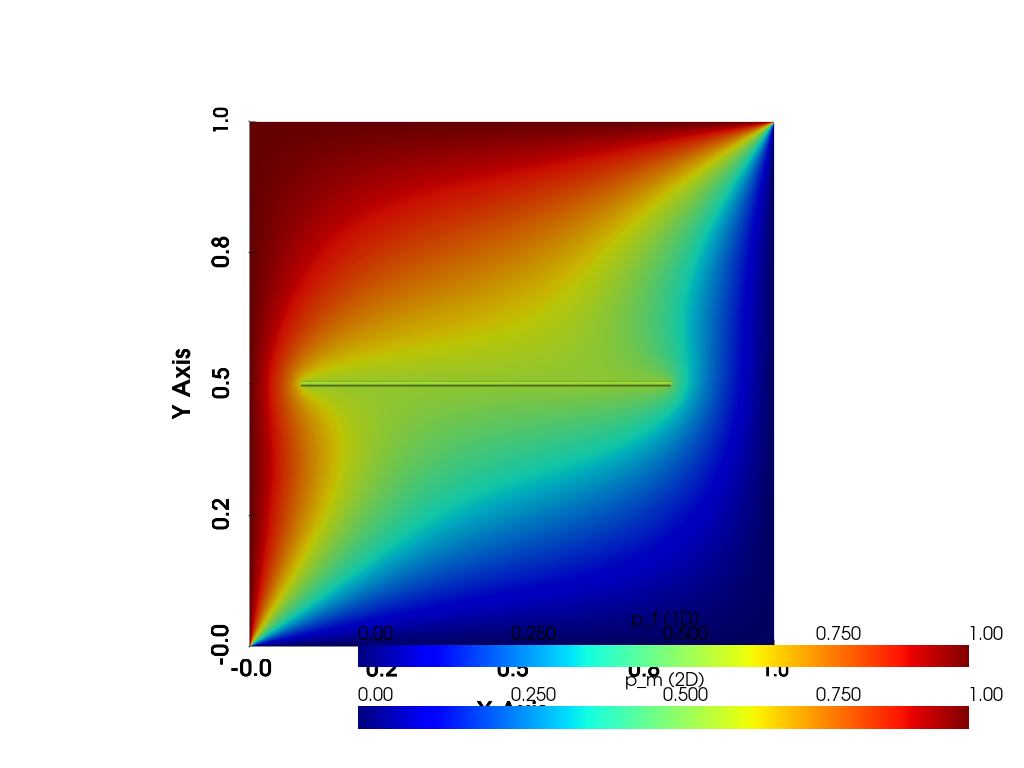

In [66]:
import numpy as np
import pyvista as pv
from dolfinx import plot

# --- Convert 2D field (p_m) ---
topology2, cell_types2, geometry2 = plot.vtk_mesh(p_m.function_space)
grid_2d = pv.UnstructuredGrid(topology2, cell_types2, geometry2)
grid_2d.point_data["p_m"] = p_m.x.array.real

# --- Convert 1D field (p_f) ---
topology1, cell_types1, geometry1 = plot.vtk_mesh(p_f.function_space)
grid_1d = pv.UnstructuredGrid(topology1, cell_types1, geometry1)
grid_1d.point_data["p_f"] = p_f.x.array.real

# --- Create plotter ---
plotter = pv.Plotter()

# Add 2D mesh with filled colormap
plotter.add_mesh(
    grid_2d,
    scalars="p_m",
    cmap="jet",
    show_edges=False,
    lighting=True,
    scalar_bar_args={"title": "p_m (2D)"}, clim=[vmin, vmax]
)

# Add 1D interface as a line on top, thicker and with its own scalar color
plotter.add_mesh(
    grid_1d,
    scalars="p_f",
    cmap="jet",
    line_width=5,
    show_edges=False,
    render_lines_as_tubes=True,
    scalar_bar_args={"title": "p_f (1D)"}, clim=[vmin, vmax]
)

# --- Cosmetics ---
plotter.show_bounds()
plotter.view_xy()
plotter.show()

In [67]:
from dolfinx.io import XDMFFile
from mpi4py import MPI

with XDMFFile(MPI.COMM_SELF, "solution.xdmf", "w") as xdmf:
    xdmf.write_mesh(p_m.function_space.mesh)
    xdmf.write_function(p_m)
    xdmf.write_function(p_f)
    xdmf.write_function(lmbd)

/home/muchamad/PhD/fenicsx/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


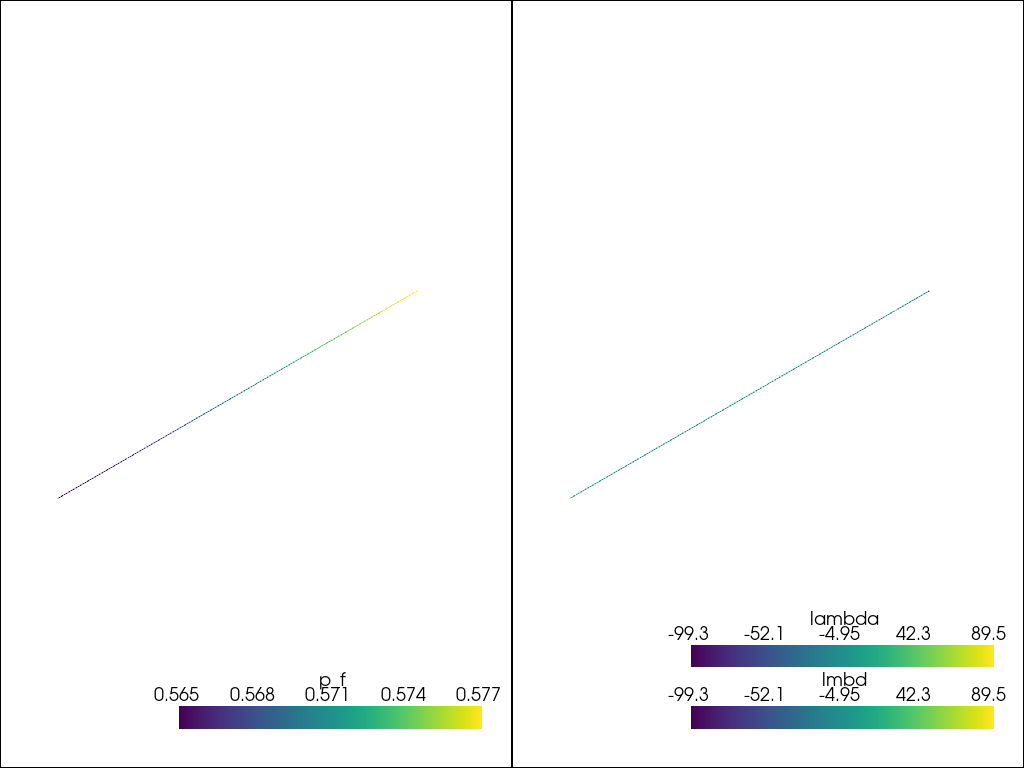

In [68]:
import pyvista as pv
import numpy as np
from dolfinx import plot

def grid_from_function(u):
    V = u.function_space
    topo, cell_types, geom = plot.vtk_mesh(V)        # dof (nodal) coordinates
    grid = pv.UnstructuredGrid(topo, cell_types, geom)
    grid.point_data[u.name if u.name else "field"] = u.x.array
    return grid

g_pf   = grid_from_function(p_f)
g_lmbd = grid_from_function(lmbd)

p = pv.Plotter(shape=(1, 2))
p.subplot(0, 0); p.add_mesh(g_pf, scalars=g_pf.point_data.keys().__iter__().__next__(),
                           show_edges=False); p.add_scalar_bar("p_f")
p.subplot(0, 1); p.add_mesh(g_lmbd, scalars=g_lmbd.point_data.keys().__iter__().__next__(),
                           show_edges=False); p.add_scalar_bar("lambda")
p.link_views(); p.show()
